# Deep Learning – LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/processed_train.csv", parse_dates=["Date"])


Date
2013-01-01      97235
2013-01-02    6949829
2013-01-03    6347820
2013-01-04    6638954
2013-01-05    5951593
Freq: D, Name: Sales, dtype: int64


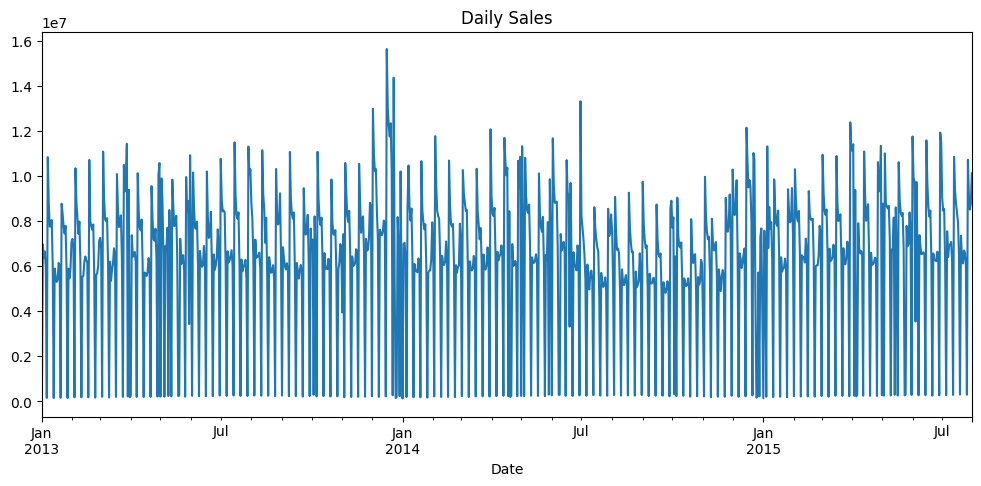

In [ ]:
train = train[train["Open"] == 1]

ts = (
    train
    .groupby("Date")["Sales"]
    .sum()
    .asfreq("D")
    .fillna(0)
)

print(ts.head())

ts.plot(figsize=(12,5))
plt.title("Daily Sales")
plt.show()

#### We model a high-activity store to reduce noise and capture clearer patterns.

### Chronological Split (Forecast 6 weeks ahead)

In [ ]:
forecast_horizon = 42

train_ts = ts[:-forecast_horizon]
test_ts = ts[-forecast_horizon:]
print(train_ts.shape, test_ts.shape)


(900,) (42,)


### Prepare Sequences

In [ ]:
# Scaling to (-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))

train_scaled = scaler.fit_transform(train_ts.values.reshape(-1,1))
test_scaled = scaler.transform(test_ts.values.reshape(-1,1))

# Sliding Window Sequences Creation
def create_sequences(data, window=30):
    x, y = [], []
    for i in range(len(data)-window):
        x.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(x), np.array(y)

window_size = 30

x_train, y_train = create_sequences(train_scaled, window_size)
print(x_train.shape, y_train.shape)


(870, 30, 1) (870, 1)


In [ ]:
# Reshape:
split = int(len(x_train)*0.8)

x_train, x_val = x_train[:split], x_train[split:]
y_train, y_val = y_train[:split], y_train[split:]

x_train = x_train.reshape((-1,window_size,1))
X_val = x_val.reshape((-1,window_size,1))


## LSTM Model

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size,1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

#### Training with EarlyStopping

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.1852 - val_loss: 0.1423
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1657 - val_loss: 0.1359
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1600 - val_loss: 0.1430
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1518 - val_loss: 0.1411
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1511 - val_loss: 0.1410
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1630 - val_loss: 0.1415
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1557 - val_loss: 0.1457


### Plot Loss

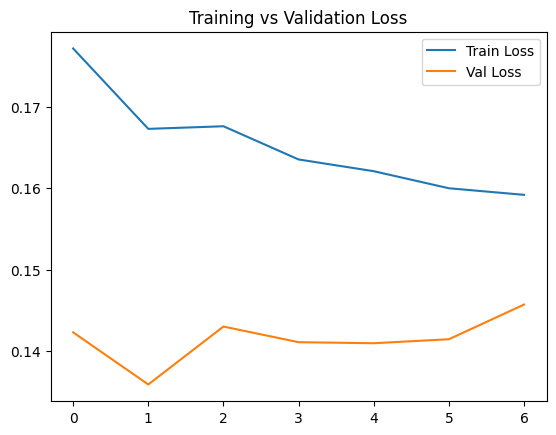

In [ ]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")

plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### Predictions & Inverse Scaling

In [ ]:
preds = model.predict(x_val)

preds_inv = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_val)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


#### Evaluation

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
mape = mean_absolute_percentage_error(y_test_inv, preds_inv)

print("RMSE:", rmse)
print("MAPE:", mape)


RMSE: 2862026.3827274493
MAPE: 4.399932359543873


#### Plot Forecast vs Actual (6 weeks)

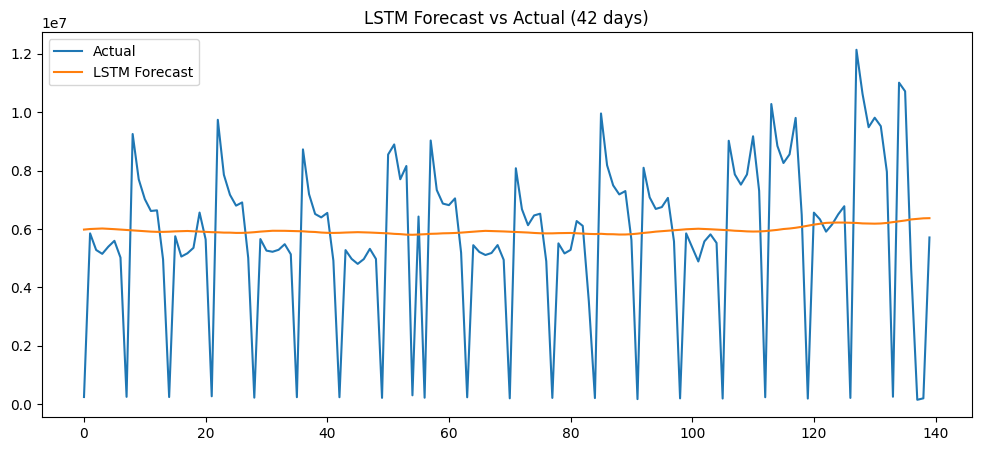

In [ ]:
y_test_inv = y_test_inv.flatten()
preds_inv = preds_inv.flatten()

plt.figure(figsize=(12,5))

plt.plot(y_test_inv,
         label="Actual")

plt.plot(preds_inv,
         label="LSTM Forecast")

plt.legend()
plt.title("LSTM Forecast vs Actual (42 days)")
plt.show()


### 42-Day Future Forecast

In [ ]:
scaled = scaler.transform(ts.values.reshape(-1,1))

last_window = scaled[-window_size:]
current = last_window.reshape(1,window_size,1)

future_scaled=[]

for _ in range(42):
    next_pred = model.predict(current ,verbose=0)[0,0]
    future_scaled.append(next_pred)

    current = np.append(current[:,1:,:],[[[next_pred]]],axis=1)

future_preds = scaler.inverse_transform(
    np.array(future_scaled).reshape(-1,1)
)


In [ ]:
# Future Dates and Table
future_dates = pd.date_range(
    start=ts.index[-1]+pd.Timedelta(days=1),
    periods=42
)

forecast_df = pd.DataFrame({
    "Date":future_dates,
    "Forecasted_Sales":future_preds.flatten()
})

forecast_df.head()

,Date,Forecasted_Sales
0,2015-08-01,6157323.5
1,2015-08-02,6170324.0
2,2015-08-03,6188678.0
3,2015-08-04,6213233.0
4,2015-08-05,6245541.0


### Forecast Plot

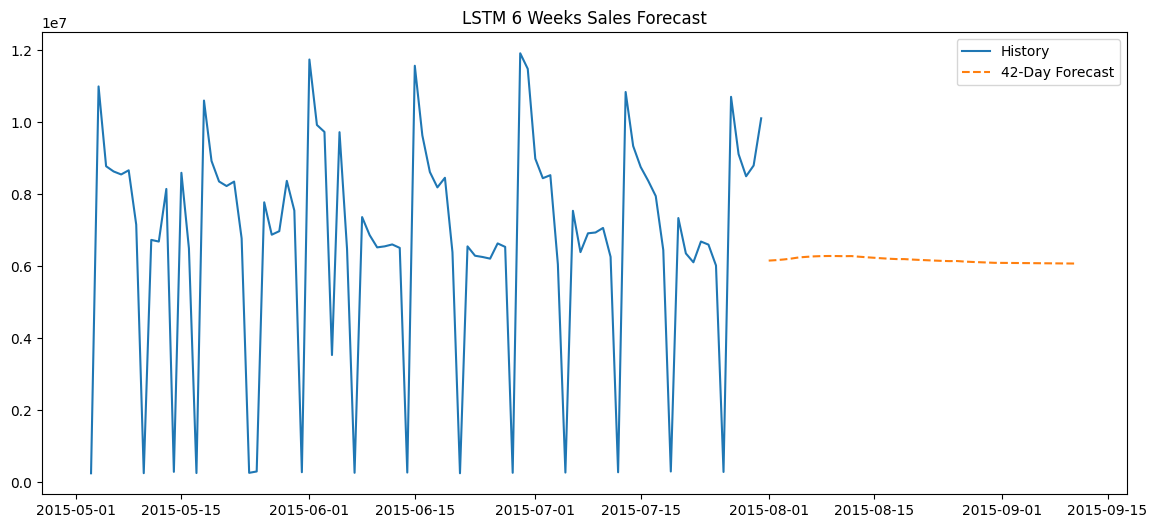

In [ ]:
plt.figure(figsize=(14,6))

plt.plot(ts.index[-90:],ts.values[-90:],label="History")
plt.plot(future_dates,future_preds,
         label="42-Day Forecast",
         linestyle="--")

plt.legend()
plt.title("LSTM 6 Weeks Sales Forecast")
plt.show()


### SAVE FORECAST

In [ ]:
forecast_df.to_csv(
    "/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/lstm_42day_forecast.csv",
    index=False)

### Insights:

#### Sales exhibit strong temporal and non-linear patterns.

#### LSTM captures sequential dependencies better than ARIMA.

#### Random Forest remains competitive due to external features.
